In [1]:
'''
pip install ipywidgets --upgrade
'''

'\npip install ipywidgets --upgrade\n'

In [ ]:

# %pip install ipywidgets --upgrade
# %pip install -r ../requirements-dev.txt  # to install the orchestrator package
# %pip install -U ../.  # to install the orchestrator package

In [ ]:
import os
from pathlib import Path
import sys
base_path = Path(os.path.abspath("")).parent
sys.path.append(base_path.as_posix())
base_path.as_posix()

In [5]:

import logging
import random
import shutil
from pathlib import Path
from typing import Any
import os

import numpy as np  # type: ignore
import pandas as pd # type: ignore
import tensorflow as tf  # type: ignore
import torch  # type: ignore
import matplotlib.pyplot as plt

from fluidos_model_orchestrator.data_pipeline.augmentation.augmentation_utils import AUGMENTATION_TYPES
from fluidos_model_orchestrator.data_pipeline.data_util import FLUIDOS_DATASETS
from fluidos_model_orchestrator.data_pipeline.data_util import get_target_column
from fluidos_model_orchestrator.data_pipeline.data_util import load_ml_ready_df
from fluidos_model_orchestrator.model.utils import MODEL_TYPES
from fluidos_model_orchestrator.model_pipeline.model_trainer_factory import ModelTrainerFactory
from fluidos_model_orchestrator.model.utils import FLUIDOS_COL_NAMES

import ipywidgets as widgets
widgets.IntSlider()

tf.random.set_seed(42)
torch.manual_seed(42)
random.seed(42)

## Hyperparameters

In [6]:
ROOT_DIR = Path(os.getcwd()).parent.parent

platform = "ccc"  # "local"
dataset_name = FLUIDOS_DATASETS.BITBRAINS  # FLUIDOS_DATASETS.GCT
model_type = MODEL_TYPES.CG  # MODEL_TYPES.FLUIDOS_RANKER
augmentation = AUGMENTATION_TYPES.FEEDBACK_LOOP  # AUGMENTATION_TYPES.PERFORMANCE_RATING

epochs = 5
load_from_generated = 0
test_mode = False
max_pod = 2000
tr_number = 50 # -1 for gct

path_output_model = "<INSERT_YOUR_PATH_HERE>"
path_output = "<INSERT_YOUR_PATH_HERE>"

dataset_subset = "rnd"

#DATASETS can be downloaded here: https://drive.google.com/drive/folders/13sNpT5ycd7XHPFcpEHEVQ1RtctMQADcK
path_dataset_ml_ready = "<INSERT_YOUR_PATH_HERE>"
# path_dataset_ml_ready = "<INSERT_YOUR_PATH_HERE>/ibm_telefonica_dataset"

MODEL_GLOBAL = "model_global"
MODEL_GLOBAL_UPDATED = "model_global_updated"
FED_MODELS_TRAINED = [MODEL_GLOBAL, "model_B", "model_C"]

In [7]:
def split_dataset(df: pd.DataFrame, model_names: list[str], model_source_name: str, train_ratio: float = 0.2, test_ratio: float = 0.05) -> dict[str, dict[str, Any]]:

    manifests = df[[FLUIDOS_COL_NAMES.POD_FILE_NAME, FLUIDOS_COL_NAMES.POD_MANIFEST]]
    counts = manifests[FLUIDOS_COL_NAMES.POD_MANIFEST].value_counts().to_dict()
    # Estimation of pod manifests distribution
    frequency_per_pod = []
    for index, row in manifests.iterrows():
        frequency_per_pod.append(counts[row[FLUIDOS_COL_NAMES.POD_MANIFEST]])

    manifests.insert(2, "frequency", frequency_per_pod)
    manifests = manifests.sort_values(by="frequency", ascending=False)
    manifests["frequency"] = manifests["frequency"] / len(manifests)
    manifests.index = range(len(manifests.index))
    manifests = manifests.reset_index()

    manifests_size = len(manifests)

    train_size = int(train_ratio * manifests_size)
    test_size = int(test_ratio * manifests_size) 
    test_manifests = manifests.sample(test_size)

    train_manifests = manifests[:train_size]
    local_manifests = manifests[train_size:]

    train_pods = df[df[FLUIDOS_COL_NAMES.POD_FILE_NAME].isin(train_manifests[FLUIDOS_COL_NAMES.POD_FILE_NAME])]
    local_pods = df[df[FLUIDOS_COL_NAMES.POD_FILE_NAME].isin(local_manifests[FLUIDOS_COL_NAMES.POD_FILE_NAME])]
    test_pods = df[df[FLUIDOS_COL_NAMES.POD_FILE_NAME].isin(test_manifests[FLUIDOS_COL_NAMES.POD_FILE_NAME])]
    split_size = len(local_pods) // (len(model_names) - 1)
    local_pods_chunks = [local_pods[i:i + split_size] for i in range(0, len(local_pods), split_size)]

    model_attributes = {}
    model_attributes[MODEL_GLOBAL] = {"df_train": train_pods, "df_test": test_pods}
    for index, model_name in enumerate(model_names[1:]):
        model_attributes[model_name] = {"df_train": local_pods_chunks[index],
                                        "df_test": test_pods}
            
    return model_attributes

## Preparing Datasets

In [ ]:
logging.info("Starting Model Building and Training")

ml_ready_dataset_path = Path(path_dataset_ml_ready)

pods_assigment_df, template_resources_df = load_ml_ready_df(ml_ready_dataset_path)

#TODO TMP - remove this when all tested 
# pods_assigment_df = pods_assigment_df[:10000]

model_attributes = split_dataset(pods_assigment_df, FED_MODELS_TRAINED, MODEL_GLOBAL)

pods_assigment_df## Setting up model Trainers

In [ ]:
# Time consuming step for the first run, if run for the second time set load_from_generated=True at the beginning of the notebook
if dataset_name == FLUIDOS_DATASETS.BITBRAINS:
    total_pods = max_pod * tr_number
else:
    total_pods = max_pod
    
for model_name in FED_MODELS_TRAINED:
    model_trainer = ModelTrainerFactory.create_model_trainer(model_type,
                                                             ml_ready_dataset_path,
                                                             Path(path_output).joinpath("model_training"),
                                                             max_pod=total_pods,
                                                             epochs=epochs,
                                                             target_column=get_target_column(augmentation),
                                                             load_from_generated=load_from_generated,
                                                             model_name=model_name)
    model_trainer.prepare_directories()
    model_attributes[model_name]["trainer"] = model_trainer

for model_name in FED_MODELS_TRAINED:
    TRAINING_RATIO = 1.0
    cached_train = model_attributes[model_name]["trainer"].prepare_dataset(model_attributes[model_name]['df_train'],
                                                                           template_resources_df, test_mode,
                                                                           training_size_ratio=TRAINING_RATIO,
                                                                           model_tag=model_name, dataset_type="train")
    cached_test = model_attributes[model_name]["trainer"].prepare_dataset(model_attributes[model_name]['df_test'],
                                                                          template_resources_df, test_mode,
                                                                          training_size_ratio=TRAINING_RATIO,
                                                                          model_tag=model_name, dataset_type="test")
    model_attributes[model_name]["trainer"].cached_train = cached_train
    model_attributes[model_name]["trainer"].cached_test = cached_test

## Training Global model

In [10]:

model_attributes[MODEL_GLOBAL]["trainer"].build_model()
model_attributes[MODEL_GLOBAL]["trainer"].check_model_dataset_depencies()
model_attributes[MODEL_GLOBAL]["trainer"].train_model()
model_attributes[MODEL_GLOBAL]["eval_results"] = model_attributes[MODEL_GLOBAL]["trainer"].evaluate()

for model_name in FED_MODELS_TRAINED:
    if model_name == MODEL_GLOBAL:
        continue
    shutil.copytree(model_attributes[MODEL_GLOBAL]["trainer"].checkpoint_path.parent.parent.parent, model_attributes[model_name]["trainer"].checkpoint_path.parent.parent.parent, dirs_exist_ok=True)

Training...


Epoch 0: 100%|██████████| 2500/2500 [00:25<00:00, 98.04batch/s, accuracy=1, loss=2.95]    


Epoch 0, train loss 3.0801 Accuracy 0.9 LR: [0.0001]


(val) Epoch 0:   0%|          | 0/641 [00:02<?, ?batch/s, v_accuracy=0.5, val_loss=3.51] 


Epoch 0, val loss 3.467 Accuracy 0.48
Current minimal val loss is 3.467043201934529.


Epoch 1: 100%|██████████| 2500/2500 [00:22<00:00, 110.52batch/s, accuracy=1, loss=2.95]   


Epoch 1, train loss 2.9722 Accuracy 0.97 LR: [0.0001]


(val) Epoch 1:   0%|          | 0/641 [00:02<?, ?batch/s, v_accuracy=0.25, val_loss=3.69]


Epoch 1, val loss 3.4219 Accuracy 0.52
Current minimal val loss is 3.421890474146874.


Epoch 2: 100%|██████████| 2500/2500 [00:22<00:00, 111.46batch/s, accuracy=1, loss=2.95]   


Epoch 2, train loss 2.9686 Accuracy 0.98 LR: [1e-05]


(val) Epoch 2:   0%|          | 0/641 [00:02<?, ?batch/s, v_accuracy=0.38, val_loss=3.57]


Epoch 2, val loss 3.406 Accuracy 0.54
Current minimal val loss is 3.4059774414425523.


Epoch 3: 100%|██████████| 2500/2500 [00:22<00:00, 112.53batch/s, accuracy=1, loss=2.95]   


Epoch 3, train loss 2.9676 Accuracy 0.98 LR: [1e-05]


(val) Epoch 3:   0%|          | 0/641 [00:02<?, ?batch/s, v_accuracy=0.62, val_loss=3.32]


Epoch 3, val loss 3.4054 Accuracy 0.54
Current minimal val loss is 3.4053735413157065.


Epoch 4: 100%|██████████| 2500/2500 [00:21<00:00, 113.77batch/s, accuracy=1, loss=2.95]   


Epoch 4, train loss 2.9676 Accuracy 0.98 LR: [1e-05]


(val) Epoch 4:   0%|          | 0/641 [00:02<?, ?batch/s, v_accuracy=0.75, val_loss=3.2] 


Epoch 4, val loss 3.4055 Accuracy 0.54
("Evaluation results: {'total_loss': 3.4054752348365724, 'accuracy': "
 '0.5399765990639626}')


## Training Child Models from Global Model

In [11]:
for model_name in FED_MODELS_TRAINED:
    if model_name == MODEL_GLOBAL:
        continue
    print(model_name)
    model_attributes[model_name]["trainer"].load_model(load_from_checkpoint=True)  # type: ignore
    model_attributes[model_name]["trainer"].train_model()
    model_attributes[model_name]["eval_results"] = model_attributes[model_name]["trainer"].evaluate()

logging.info("MODELS Evaluation Results")
for model_name in FED_MODELS_TRAINED:
    if "eval_results" in model_attributes[model_name]:
        logging.info(f"MODEL: {model_name}: {model_attributes[model_name]['eval_results']}")

logging.info(f"Pipeline output located at: {path_output_model}")


model_B
Training...


Epoch 0: 100%|██████████| 5000/5000 [00:43<00:00, 114.80batch/s, accuracy=0.88, loss=3.07]


Epoch 0, train loss 3.3291 Accuracy 0.62 LR: [0.0001]


(val) Epoch 0:   0%|          | 0/641 [00:02<?, ?batch/s, v_accuracy=1, val_loss=2.95]   


Epoch 0, val loss 3.1893 Accuracy 0.76
Current minimal val loss is 3.189333543018692.


Epoch 1: 100%|██████████| 5000/5000 [00:43<00:00, 115.98batch/s, accuracy=0.88, loss=3.07]


Epoch 1, train loss 3.2146 Accuracy 0.73 LR: [0.0001]


(val) Epoch 1:   0%|          | 0/641 [00:02<?, ?batch/s, v_accuracy=0.38, val_loss=3.57]


Epoch 1, val loss 3.1841 Accuracy 0.76
Current minimal val loss is 3.1840958628751186.


Epoch 2: 100%|██████████| 5000/5000 [00:46<00:00, 108.67batch/s, accuracy=1, loss=2.95]   


Epoch 2, train loss 3.2097 Accuracy 0.74 LR: [1e-05]


(val) Epoch 2:   0%|          | 0/641 [00:02<?, ?batch/s, v_accuracy=0.62, val_loss=3.28]


Epoch 2, val loss 3.1859 Accuracy 0.76


Epoch 3: 100%|██████████| 5000/5000 [00:47<00:00, 105.10batch/s, accuracy=0.75, loss=3.19]


Epoch 3, train loss 3.1969 Accuracy 0.75 LR: [1e-05]


(val) Epoch 3:   0%|          | 0/641 [00:02<?, ?batch/s, v_accuracy=0.88, val_loss=3.07]


Epoch 3, val loss 3.1837 Accuracy 0.76
Current minimal val loss is 3.1837276895407025.


Epoch 4: 100%|██████████| 5000/5000 [00:49<00:00, 100.85batch/s, accuracy=0.75, loss=3.19]


Epoch 4, train loss 3.1966 Accuracy 0.75 LR: [1e-05]


(val) Epoch 4:   0%|          | 0/641 [00:02<?, ?batch/s, v_accuracy=0.62, val_loss=3.32]


Epoch 4, val loss 3.1836 Accuracy 0.76
Current minimal val loss is 3.1836354680440726.
("Evaluation results: {'total_loss': 3.1836354680440726, 'accuracy': "
 '0.7611154446177847}')
model_C
Training...


Epoch 0: 100%|██████████| 5000/5000 [01:01<00:00, 81.91batch/s, accuracy=0.75, loss=3.2]  


Epoch 0, train loss 3.2133 Accuracy 0.73 LR: [0.0001]


(val) Epoch 0:   0%|          | 0/641 [00:03<?, ?batch/s, v_accuracy=0.62, val_loss=3.32]


Epoch 0, val loss 3.3299 Accuracy 0.62
Current minimal val loss is 3.3298555432169374.


Epoch 1: 100%|██████████| 5000/5000 [01:08<00:00, 73.14batch/s, accuracy=0.5, loss=3.44]  


Epoch 1, train loss 3.1771 Accuracy 0.77 LR: [0.0001]


(val) Epoch 1:   0%|          | 0/641 [00:02<?, ?batch/s, v_accuracy=0.75, val_loss=3.2] 


Epoch 1, val loss 3.3385 Accuracy 0.61


Epoch 2: 100%|██████████| 5000/5000 [00:46<00:00, 106.45batch/s, accuracy=0.75, loss=3.2] 


Epoch 2, train loss 3.2037 Accuracy 0.74 LR: [1e-05]


(val) Epoch 2:   0%|          | 0/641 [00:02<?, ?batch/s, v_accuracy=0.62, val_loss=3.32]


Epoch 2, val loss 3.3168 Accuracy 0.63
Current minimal val loss is 3.316786613553623.


Epoch 3: 100%|██████████| 5000/5000 [00:46<00:00, 108.13batch/s, accuracy=0.88, loss=3.07]


Epoch 3, train loss 3.2162 Accuracy 0.73 LR: [1e-05]


(val) Epoch 3:   0%|          | 0/641 [00:02<?, ?batch/s, v_accuracy=0.25, val_loss=3.69]


Epoch 3, val loss 3.3167 Accuracy 0.63
Current minimal val loss is 3.3166690962548935.


Epoch 4: 100%|██████████| 5000/5000 [00:46<00:00, 108.30batch/s, accuracy=0.88, loss=3.07]


Epoch 4, train loss 3.2162 Accuracy 0.73 LR: [1e-05]


(val) Epoch 4:   0%|          | 0/641 [00:02<?, ?batch/s, v_accuracy=0.75, val_loss=3.2] 


Epoch 4, val loss 3.3153 Accuracy 0.63
Current minimal val loss is 3.315338502250112.
("Evaluation results: {'total_loss': 3.315338502250112, 'accuracy': "
 '0.6290951638065523}')


## Federated Learning POC

Idea: send averaged updates from model_B(Mb) and model_C(Mc) to update the model_global (Ms -> Ms').

In [12]:
FED_MODELS_TRAINED.append(MODEL_GLOBAL_UPDATED)

In [13]:
# Generation of averaged local model updates
model_source_weights = model_attributes[MODEL_GLOBAL]["trainer"].orchestrator.state_dict().values()
model_B_weights = model_attributes['model_B']["trainer"].orchestrator.state_dict().values()
model_C_weights = model_attributes['model_C']["trainer"].orchestrator.state_dict().values()

model_b_s_update = [(x - y) for x, y in zip(model_B_weights, model_source_weights)]
model_c_s_update = [(x - y) for x, y in zip(model_C_weights, model_source_weights)]
averaged_update = [0.5*(x + y) for x, y in zip(model_b_s_update, model_c_s_update)]
# updated weights: Ms’ = Ms + 0.5*((Ms-Mb) + (Ms-Mc))
model_global_weights = [x + y for x, y in zip(averaged_update, model_source_weights)]


In [15]:
# Creation of the Global model object
model_attributes[MODEL_GLOBAL_UPDATED] = {}
model_attributes[MODEL_GLOBAL_UPDATED]["trainer"] = ModelTrainerFactory.create_model_trainer(model_type,
                                                                                             ml_ready_dataset_path,
                                                                                             Path(path_output).joinpath("model_training"),
                                                                                             max_pod=total_pods,
                                                                                             epochs=epochs,
                                                                                             target_column=get_target_column(augmentation),
                                                                                             load_from_generated=True,
                                                                                             model_name=MODEL_GLOBAL_UPDATED)
model_attributes[MODEL_GLOBAL_UPDATED]["trainer"].prepare_directories()
model_attributes[MODEL_GLOBAL_UPDATED]["df_train"] = model_attributes[MODEL_GLOBAL]["df_train"].copy()
model_attributes[MODEL_GLOBAL_UPDATED]["df_test"] = model_attributes[MODEL_GLOBAL]["df_test"].copy()
shutil.copytree(model_attributes[MODEL_GLOBAL]["trainer"].checkpoint_path.parent.parent.parent, model_attributes[MODEL_GLOBAL_UPDATED]["trainer"].checkpoint_path.parent.parent.parent, dirs_exist_ok=True)

TRAINING_RATIO = 1.0
cached_train = model_attributes[MODEL_GLOBAL_UPDATED]["trainer"].prepare_dataset(model_attributes[MODEL_GLOBAL]['df_train'],
                                                                                 template_resources_df, test_mode,
                                                                                 training_size_ratio=TRAINING_RATIO,
                                                                                 model_tag=MODEL_GLOBAL, dataset_type="train")
cached_test = model_attributes[MODEL_GLOBAL_UPDATED]["trainer"].prepare_dataset(model_attributes[MODEL_GLOBAL]['df_test'],
                                                                                template_resources_df, test_mode,
                                                                                training_size_ratio=TRAINING_RATIO,
                                                                                model_tag=MODEL_GLOBAL, dataset_type="test")
model_attributes[model_name]["trainer"].cached_train = cached_train
model_attributes[model_name]["trainer"].cached_test = cached_test
    
    
model_attributes[MODEL_GLOBAL_UPDATED]["trainer"].build_model()

Creating model trainer
Preparing directories


OrchestrationModel(
  (config_embedding): Embedding(50, 8)
  (config_embedding_dropout): Dropout(p=0.2, inplace=False)
  (pod_embedding): Embedding(119547, 512)
  (embedding_aggregator): EmbeddingAggregation()
  (linear1): Linear(in_features=528, out_features=1024, bias=True)
  (activation1): ReLU(inplace=True)
  (batch_norm1): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout1): Dropout(p=0.7, inplace=False)
  (fc_layer1): Sequential(
    (0): Linear(in_features=528, out_features=1024, bias=True)
    (1): ReLU(inplace=True)
    (2): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.7, inplace=False)
  )
  (linear2): Linear(in_features=1024, out_features=512, bias=True)
  (activation2): ReLU(inplace=True)
  (batch_norm2): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout2): Dropout(p=0.35, inplace=False)
  (fc_layer2): Sequential(
    (0): Linear(in_

In [16]:
# load the updated model weights Ms' and evluate the model with the common test subset
from collections import OrderedDict

model_global_weights_dict = {}
index = 0
for key in model_attributes[MODEL_GLOBAL_UPDATED]["trainer"].orchestrator.state_dict():
    model_global_weights_dict[key] = model_global_weights[index]
    index += 1
model_attributes[MODEL_GLOBAL_UPDATED]["trainer"].orchestrator.load_state_dict(OrderedDict(model_global_weights_dict))    
model_attributes[MODEL_GLOBAL_UPDATED]["trainer"].orchestrator.eval()

model_attributes[MODEL_GLOBAL_UPDATED]["trainer"].validate_model()
model_attributes[MODEL_GLOBAL_UPDATED]["eval_results"] = model_attributes[MODEL_GLOBAL_UPDATED]["trainer"].evaluate()

(val) Epoch 0:   0%|          | 0/641 [00:02<?, ?batch/s, v_accuracy=0.88, val_loss=3.07]


("Evaluation results: {'total_loss': 3.1751974696488166, 'accuracy': "
 '0.7767160686427457}')


## Evaluation

In [17]:
if model_type == MODEL_TYPES.CG:
    results_df = pd.DataFrame(index=['accuracy', 'total_loss'], columns=FED_MODELS_TRAINED)

    for model_name in FED_MODELS_TRAINED:
        for metric, value in model_attributes[model_name]["eval_results"].items():
            results_df.loc[metric, model_name] = value
elif MODEL_TYPES.FLUIDOS_RANKER:
    results_df = pd.DataFrame(index=['root_mean_squared_error','loss','regularization_loss','total_loss'], columns=FED_MODELS_TRAINED)

    for model_name in FED_MODELS_TRAINED:
        for metric, value in model_attributes[model_name]["eval_results"].items():
            results_df.loc[metric, model_name] = value

results_df

,model_global,model_B,model_C,model_global_updated
accuracy,0.539977,0.761115,0.629095,0.776716
total_loss,3.405475,3.183635,3.315339,3.175197


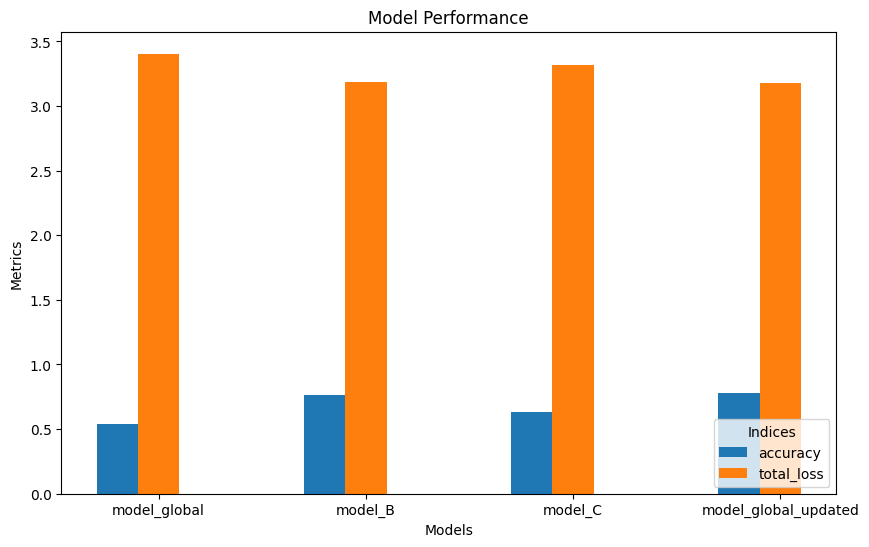

In [18]:
%matplotlib inline


plt.figure(figsize=(10, 6))



bar_width = 0.2
bar_positions = np.arange(len(results_df.columns))


for i, index in enumerate(results_df.index):
    plt.bar(
        bar_positions + i * bar_width,
        results_df.loc[index],
        width=bar_width,
        label=index
    )

plt.xlabel('Models')
plt.ylabel('Metrics')
plt.title('Model Performance')
plt.xticks(bar_positions + bar_width, results_df.columns)
plt.legend(title='Indices', loc='lower right')

plt.show()
